In [1]:
%load_ext autoreload
%autoreload 2
import HammingCode
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erfc
import NeuralNetworkCorrection as network
import Autoencoder
import math
import Utils

2024-06-03 09:05:09.709440: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 09:05:09.709572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 09:05:09.816822: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-03 09:05:10.047054: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 09:05:12.327549: W tensorflow/compiler/tf2

In [2]:
variancia = 1
code_rate = 4/7
# amostra
Eb_dB_values = np.arange(3, 16, 1)



# Gerar dados de treinamento
training_sample_length = 10 ** 5
epoches = 100
batch_size = 32

In [3]:
training_data = {
    'original': [],
    'noisy': [],
    'info': []
}

training_information = network.get_training_data_set(training_sample_length)

for eb_db in Eb_dB_values:
    info = network.generate_data_for_training(training_information, eb_db, variancia)
    training_data['noisy'].extend(info['split_noisy_original_data_15_11'])
    training_data['original'].extend(info['split_original_data_15_11'])

training_data['noisy'] = np.array(training_data['noisy'])
training_data['original'] = np.array(training_data['original'])

In [6]:
# Criar e treinar a rede neural
model = network.train_neural_network(training_data, epoches, batch_size)

[[1 0 0 ... 1 1 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 0]
 [0 1 1 ... 1 1 0]]
Epoch 1/100
 154/3324 [>.............................] - ETA: 21s - loss: 0.5523 - accuracy: 0.1303

KeyboardInterrupt: 

In [5]:
autoencoder = Autoencoder.create_and_train_auto_encoder(training_data, epoches, batch_size)

Epoch 1/100
3694/3694 [==============================] - 16s 4ms/step - loss: 0.5440 - accuracy: 0.1540 - val_loss: 0.4980 - val_accuracy: 0.1159
Epoch 2/100
3694/3694 [==============================] - 15s 4ms/step - loss: 0.4938 - accuracy: 0.1524 - val_loss: 0.4921 - val_accuracy: 0.1004
Epoch 3/100
3694/3694 [==============================] - 15s 4ms/step - loss: 0.4905 - accuracy: 0.1475 - val_loss: 0.4896 - val_accuracy: 0.0896
Epoch 4/100
3694/3694 [==============================] - 15s 4ms/step - loss: 0.4896 - accuracy: 0.1317 - val_loss: 0.4893 - val_accuracy: 0.3806
Epoch 5/100
3694/3694 [==============================] - 15s 4ms/step - loss: 0.4892 - accuracy: 0.1314 - val_loss: 0.4889 - val_accuracy: 0.0865
Epoch 6/100
3694/3694 [==============================] - 15s 4ms/step - loss: 0.4890 - accuracy: 0.1403 - val_loss: 0.4886 - val_accuracy: 0.3513
Epoch 7/100
3694/3694 [==============================] - 15s 4ms/step - loss: 0.4889 - accuracy: 0.1438 - val_loss: 0.4898 -

In [6]:
# Gerar dados de teste
amostras_ruidosas = []
amostras_originais = []
ML_result = []
tradicional_result = []
autoencoder_result = []


In [7]:
test_data = {
    'original': [],
    'info': []
}
test_sample_length = 10 ** 3
test_information = network.get_training_data_set(test_sample_length)

total_chunks = math.floor(test_sample_length / 11)
total_length_chunks = total_chunks * 11
smaller_array_len = test_sample_length - total_length_chunks

adjustment_test = 11 - smaller_array_len

for eb_db in Eb_dB_values:
    info = network.generate_data_for_training(test_information, eb_db, variancia)
    test_data['info'].append(info)
    test_data['original'] = info['original_data']

In [8]:
i = 0
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))

In [9]:
i = 1
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))

In [10]:
i = 2
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))

In [11]:
i = 3
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))


In [12]:
i = 4
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))


In [13]:
i = 5
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))

In [14]:
i = 6
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))


In [15]:
i = 7
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))


In [16]:
i = 8
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))


In [17]:
i = 9
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))


In [18]:
i = 10
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))


In [19]:
i = 11
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))


In [20]:
i = 12
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))


In [21]:
#for i in test_data['info']:
#    tradicional_result.append(HammingCode.decode_sample(i['split_encoded_data']))

In [22]:
BER_tradicional = []
BER_autoencoder = []
BER_ML = []
paddded_array = test_data['info'][0]['padded_array']
for i in range(0, len(autoencoder_result)):
    BER_ML.append(np.sum(np.array(ML_result[i]).astype(int) != paddded_array) / len(paddded_array))
    #BER_tradicional.append(np.sum(np.array(tradicional_result[i]).astype(int) != test_data['original']) / len(test_data['original']))
    BER_autoencoder.append(np.sum(np.array(autoencoder_result[i]).astype(int) != paddded_array) / len(paddded_array))

# Calcular a BER teórica
Eb_coded = np.array([eb_db + 10*np.log10(code_rate) for eb_db in Eb_dB_values])
Eb_values = 10**(Eb_coded/10)
BER_teorica = 0.5 * erfc(np.sqrt(Eb_values))

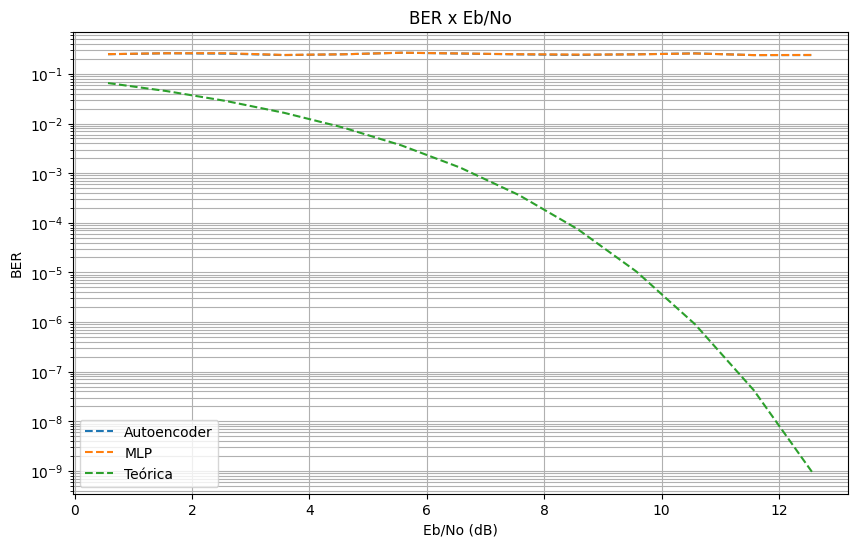

In [23]:
# Plotar as taxas de erro de bit simuladas e teóricas
plt.figure(figsize=(10, 6))
#plt.semilogy(Eb_coded, BER_tradicional, linestyle = '--', label='Codificado')
plt.semilogy(Eb_coded, BER_autoencoder, linestyle = '--', label='Autoencoder')
plt.semilogy(Eb_coded, BER_ML, linestyle = '--', label='MLP')
plt.semilogy(Eb_coded, BER_teorica, linestyle='--', label='Teórica')
plt.xlabel('Eb/No (dB)')
plt.ylabel('BER')
plt.grid(True, which='both')
plt.legend()
plt.title('BER x Eb/No')
plt.show()